In [1]:
# using Pkg
# Pkg.activate("../")

In [1]:
using PyCall
using PyPlot
using CSV, DataFrames
using JLD2
# PyPlot.svg(false)
hp = pyimport("healpy")
nmt = pyimport("pymaster")
nw = pyimport("nawrapper")

PyObject <module 'nawrapper' from '/home/zequnl/anaconda3/envs/ps/lib/python3.8/site-packages/nawrapper/__init__.py'>

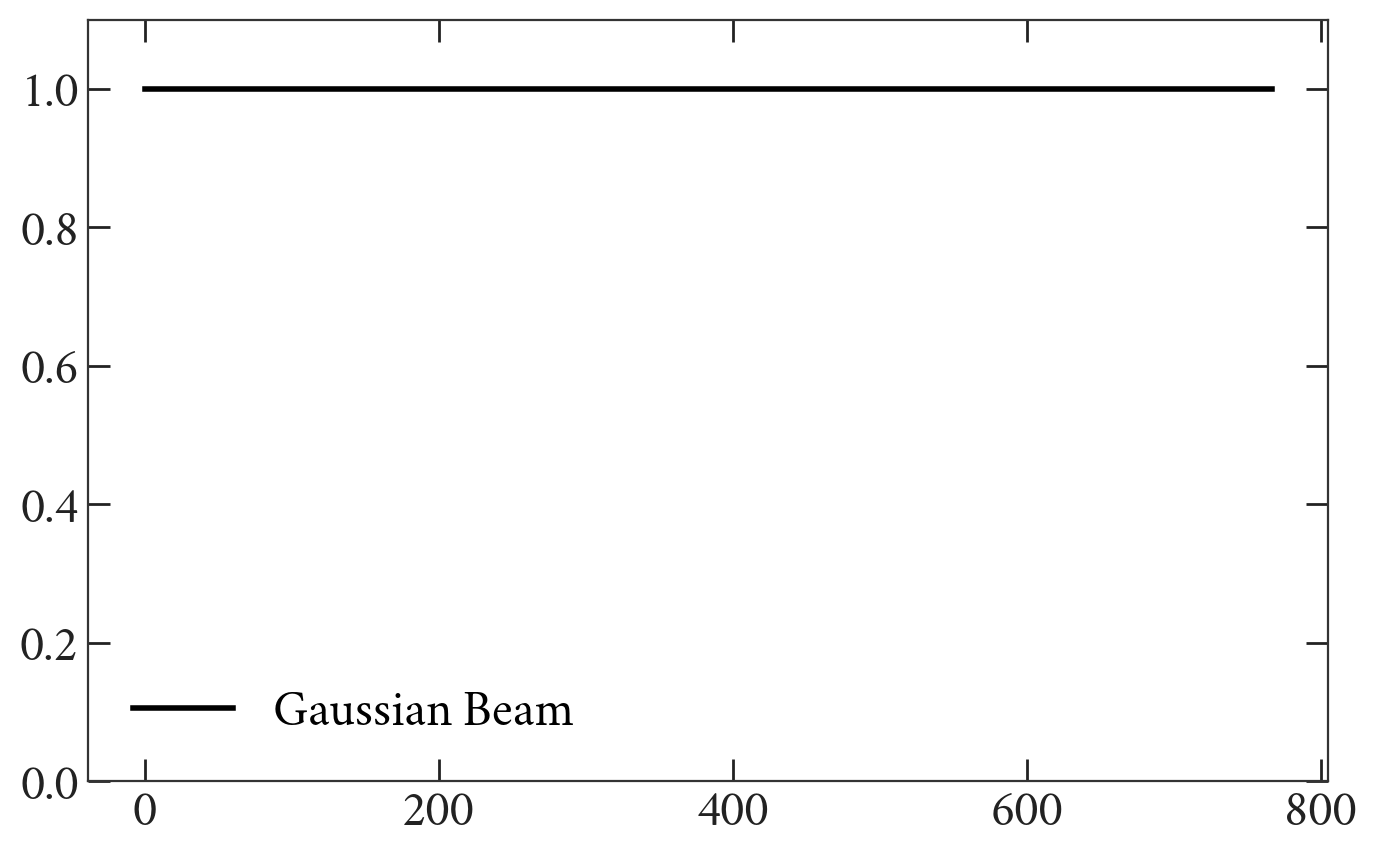

In [2]:
nside = 256
lmax = nside * 3 - 1
# B_ell = hp.sphtfunc.gauss_beam(deg2rad(0.2), lmax=lmax)
B_ell = ones(lmax+1)
ell = collect(0:lmax)
plt.plot(ell, B_ell, "-", label="Gaussian Beam")
plt.ylim(0.0, 1.1)
plt.legend();

In [3]:
beam_df = DataFrame( l = ell, Bl = B_ell);
CSV.write("data/beam.csv", beam_df)

"data/beam.csv"

In [4]:
arr = CSV.read("/home/zequnl/Projects/nawrapper/notebooks/data/example_cls.txt", comment="#", header=false)
theory_df = DataFrame(ell=arr[!,1], cltt=arr[!,2], clte=arr[!,3], clee=arr[!,4], clbb=arr[!,5]);
CSV.write("data/theory.csv", theory_df)

"data/theory.csv"

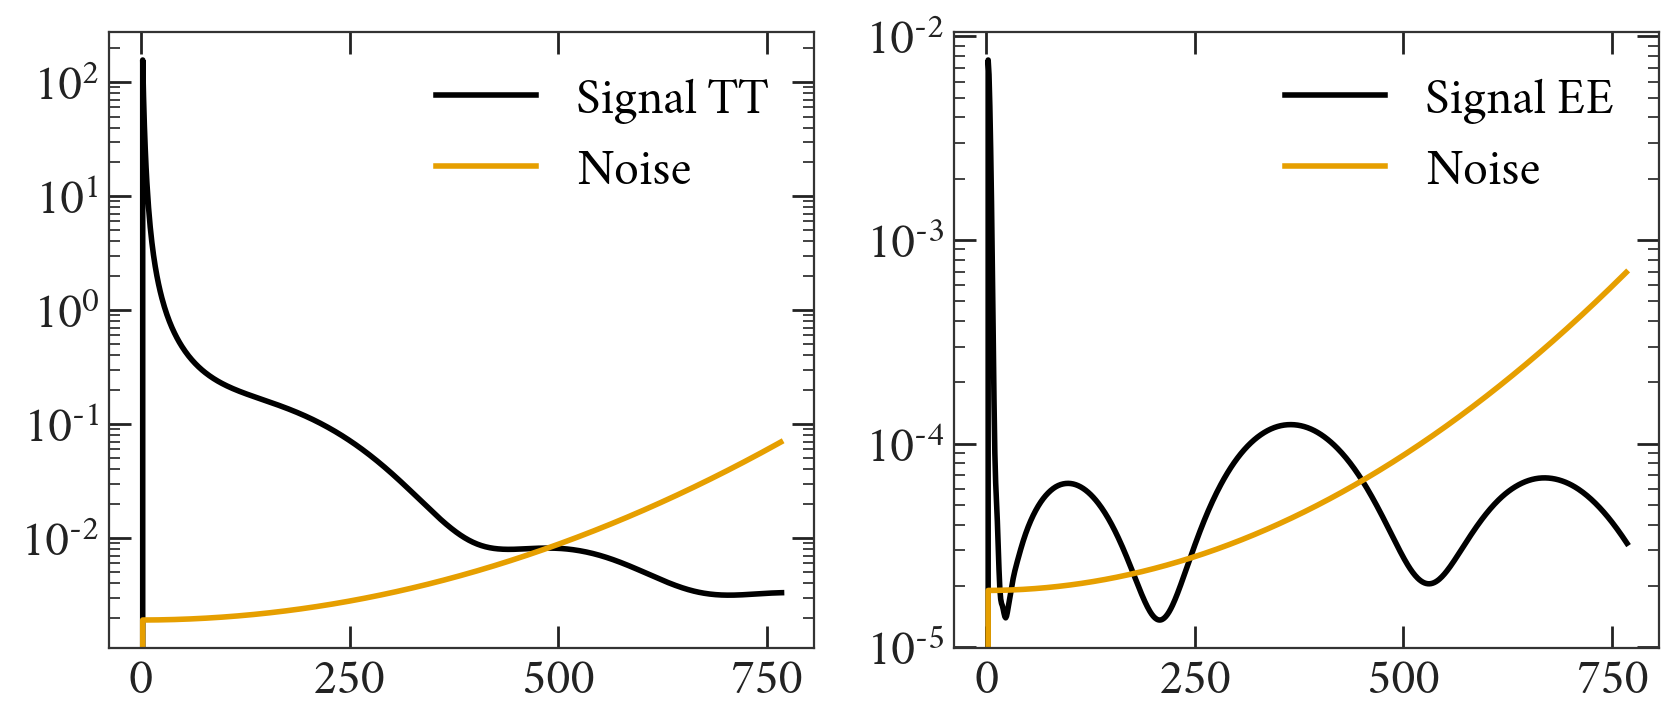

PyObject <matplotlib.legend.Legend object at 0x7f22cf1248e0>

In [5]:
nltt = nw.get_Nl(theta_fwhm=20.0, sigma_T=150, l_max=lmax+1)
nlee = nltt ./ 100
# nl[0:2] = 0.0

fig, axes = plt.subplots(1, 2, figsize=(10,4))

axes[1].plot(theory_df.cltt, "-", label="Signal TT")
axes[1].plot(nltt, "-", label="Noise")
axes[1].set_yscale("log")
axes[1].legend()

axes[2].plot(theory_df.clee, "-", label="Signal EE")
axes[2].plot(nlee, "-", label="Noise")
axes[2].set_yscale("log")
axes[2].legend()

In [6]:
noise_df = DataFrame(l=ell, nltt=nltt, nlee=nlee);
CSV.write("data/noise.csv", noise_df)

"data/noise.csv"

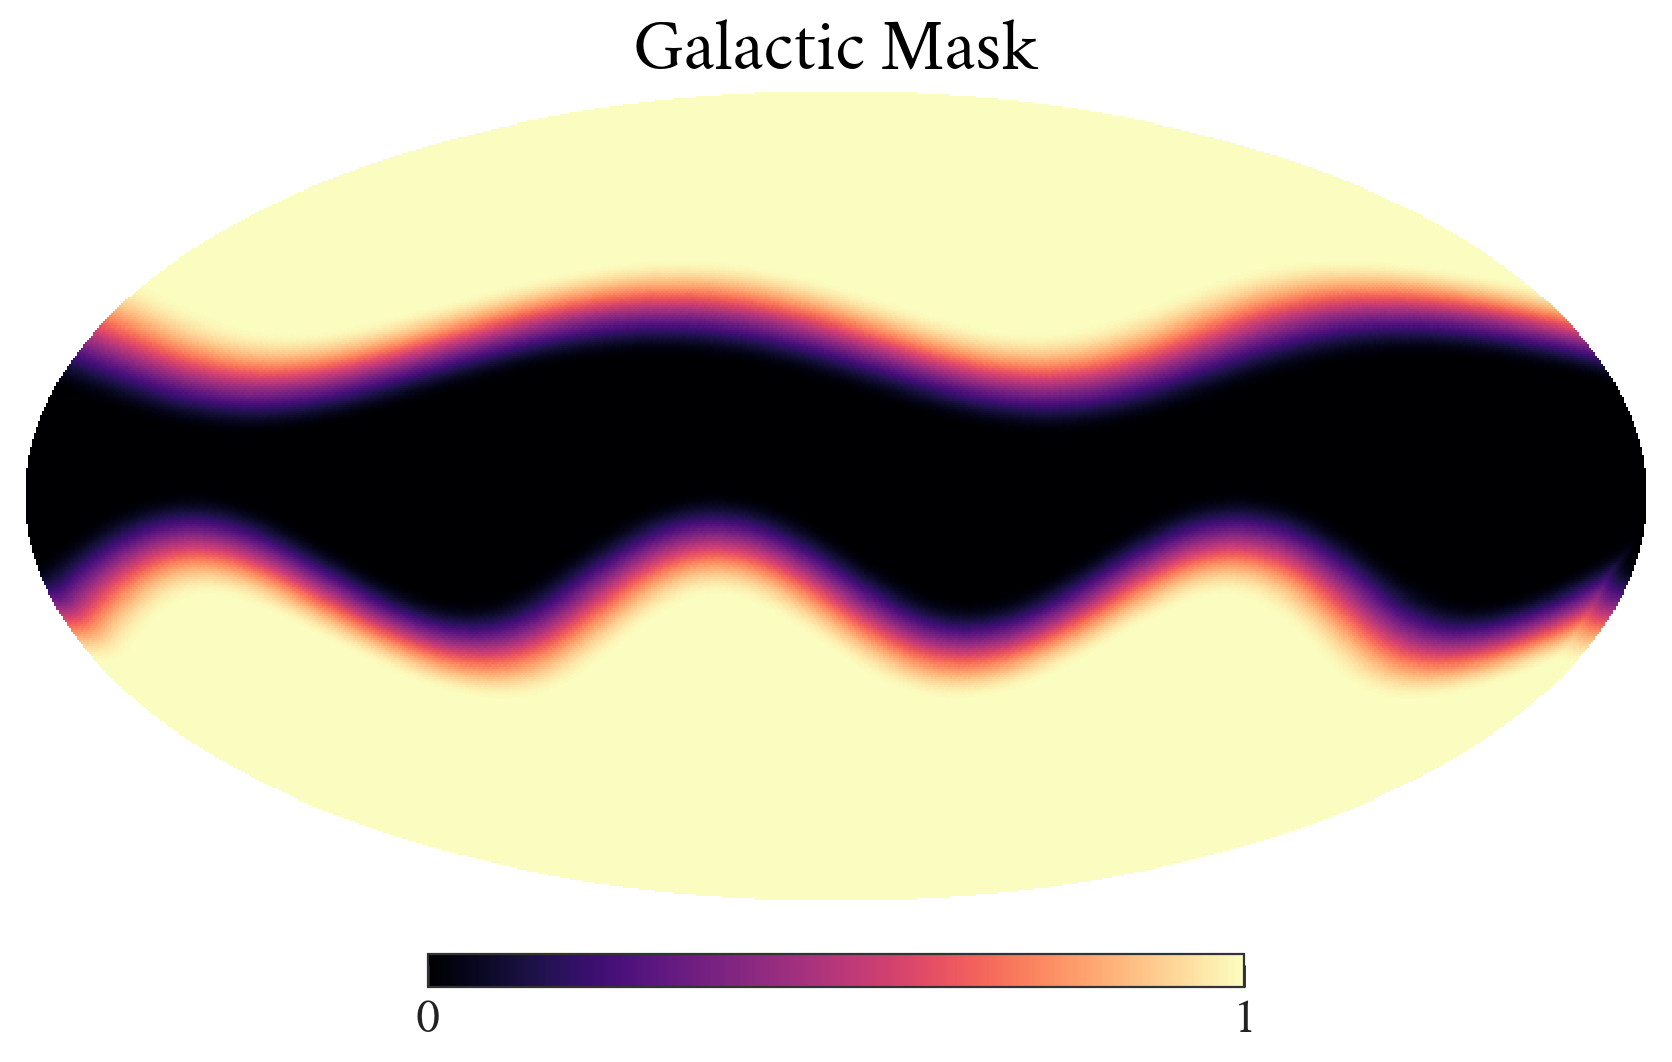

In [7]:
mask = zeros(hp.nside2npix(nside))
θ, ϕ = hp.pix2ang(nside, 0:(hp.nside2npix(nside)-1))
ϕ[ϕ .> π] .-= 2π
mask[
    (θ .* (1 .+ 0.1 .* sin.(ϕ .* 3.1 .+ 0.1)) .> 1.7) .|
    (θ .* (1 .+ 0.1 .* sin.(ϕ .* 2.0 .+ 0.1)) .< 1.25)
] .= 1.0
mask = nmt.mask_apodization(mask, 20.0, apotype="C2")
hp.mollview(mask, title="Galactic Mask")

In [8]:
using Healpix
hp_m = Map{Float64, RingOrder}(nside)
hp_m.pixels .= mask;
saveToFITS(hp_m, "!data/mask.fits")

In [9]:
pixwin = false

false

In [10]:
m = hp.synfast(
    (theory_df.cltt, theory_df.clee, theory_df.clbb, 
     theory_df.clte, zero(theory_df.cltt), zero(theory_df.cltt)), 
    nside, verbose=false, pixwin=pixwin, new=true)

hp_m = Map{Float64, RingOrder}(nside)
hp_m.pixels .= m[1,:];
saveToFITS(hp_m, "!data/map.fits")

alm = hp.map2alm(m[1,:])
@save "data/map_alm.jld2" alm

In [11]:
m = hp.synfast(
    (nltt, nlee, nlee, 
     zero(theory_df.cltt), zero(theory_df.cltt), zero(theory_df.cltt)), 
    nside, verbose=false, pixwin=pixwin, new=true)
hp_m = Map{Float64, RingOrder}(nside)
hp_m.pixels .= m[1,:];
saveToFITS(hp_m, "!data/noise1.fits")

m = hp.synfast(
    (nltt, nlee, nlee, 
     zero(theory_df.cltt), zero(theory_df.cltt), zero(theory_df.cltt)), 
    nside, verbose=false, pixwin=pixwin, new=true)
hp_m = Map{Float64, RingOrder}(nside)
hp_m.pixels .= m[1,:];
saveToFITS(hp_m, "!data/noise2.fits")

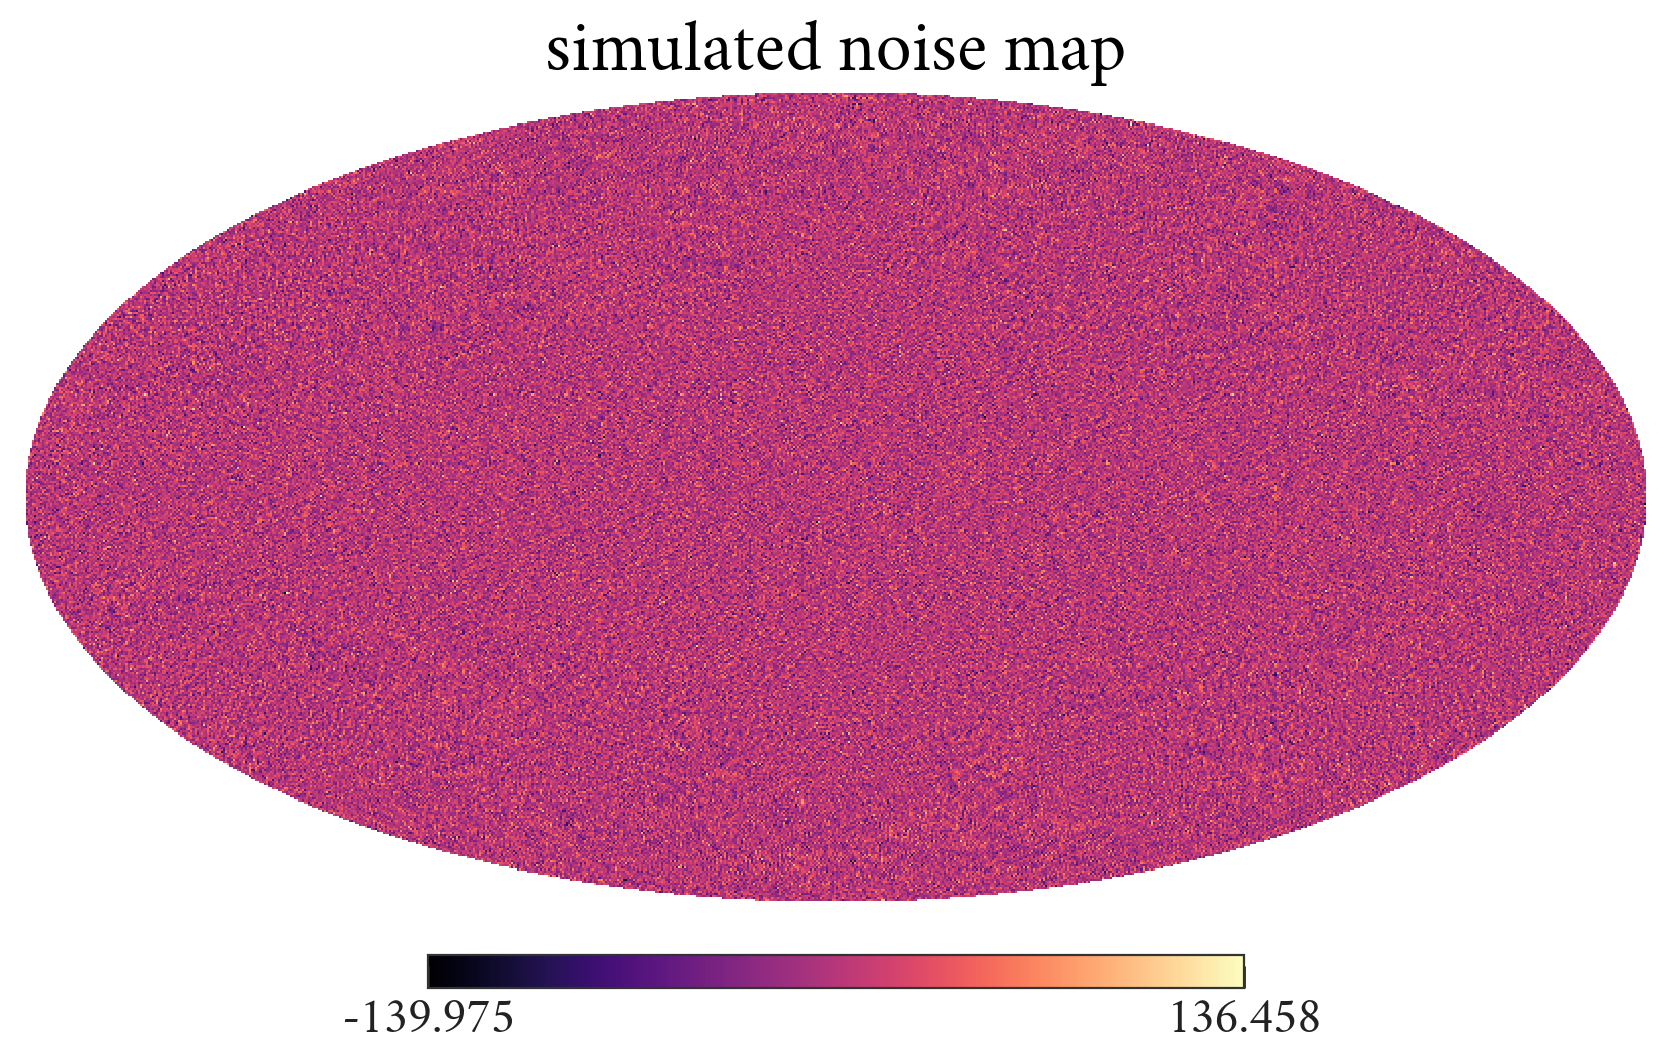

In [12]:
hp.mollview(m[1,:], title="simulated noise map")

In [13]:
using ProgressMeter

ArgumentError: ArgumentError: Package ProgressMeter not found in current path:
- Run `import Pkg; Pkg.add("ProgressMeter")` to install the ProgressMeter package.


In [17]:
l, m = hp.Alm.getlm(lmax=lmax)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9  …  764, 765, 766, 767, 765, 766, 767, 766, 767, 767], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  764, 764, 764, 764, 765, 765, 765, 766, 766, 767])

In [21]:
using JLD2

In [25]:
flat = ones(hp.nside2npix(nside))

hp_m = Map{Float64, RingOrder}(nside)
hp_m.pixels .= flat;
saveToFITS(hp_m, "!data/weight1.fits")
saveToFITS(hp_m, "!data/weight2.fits")

In [11]:
ps_list = []
@showprogress 1 for i in 1:10000
    m = hp.synfast(
        cltt,
#         (cltt, clee, clbb, 
#          clte, zero(cltt), zero(cltt)), 
        nside, verbose=false, pixwin=true, new=true)
    push!(ps_list, hp.anafast(m) )
end

Progress: 100%|█████████████████████████████████████████| Time: 0:13:33


In [12]:
sims = hcat(ps_list...);

In [14]:
@save "sims2.jld2" sims

In [15]:
# alm = hp.map2alm(m[1,:])

In [13]:
alm

UndefVarError: UndefVarError: alm not defined